<a href="https://colab.research.google.com/github/snufkin92/nlp_bert/blob/master/section_02/pytorch_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorchの基礎
PyTorchの基礎を学ぶために、ニューラルネットワークを訓練して手書き文字の認識を行います。


## データの読み込み
`torchvision.datasets`を使って手書き文字のデータを読み込み、**DataLoader**を設定します。  
DataLoaderを使うと、データの読み込みやミニバッチ法の実装などが大幅に楽になります。   
`torchvision.datasets`にはMNISTの他にも様々なデータセットが用意されています。  
https://pytorch.org/docs/stable/torchvision/datasets.html


In [13]:
import torch
from torchvision.datasets import MNIST  # 手書き文字画像のデータ
from torchvision import transforms
from torch.utils.data import DataLoader

# 訓練データを取得
mnist_train = MNIST("./data",
                    train=True, download=True,
                    transform=transforms.ToTensor())
# テストデータの取得
mnist_test = MNIST("./data",
                   train=False, download=True,
                   transform=transforms.ToTensor())
print("訓練データの数:", len(mnist_train), "テストデータの数:", len(mnist_test))

# DataLoaderの設定
img_size = 28
batch_size = 256
train_loader = DataLoader(mnist_train,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(mnist_test,
                         batch_size=batch_size,
                         shuffle=False)

訓練データの数: 60000 テストデータの数: 10000


In [14]:
print(type(mnist_train))
print(mnist_train.data.shape)
mnist_train.data[0]

<class 'torchvision.datasets.mnist.MNIST'>
torch.Size([60000, 28, 28])


tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [15]:
print(type(train_loader))
print(train_loader.dataset)

<class 'torch.utils.data.dataloader.DataLoader'>
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


手書き文字の画像サイズは、28×28になります。  



## モデルの構築
今回は、`nn.Module`モジュールを継承したクラスとして、モデルを構築します。  
`.cuda()`により、モデルの計算はGPU上で行われるようになります。  

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # 28×28の画像を784次元のベクトルに変換 => 1024 => 512 = 10クラス
        self.fc1 = nn.Linear(img_size*img_size, 1024)  # 全結合層
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, img_size*img_size)  # バッチサイズ×入力の数
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.cuda()  # GPU対応
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


## 学習
モデルを訓練します。  
DataLoaderを使い、ミニバッチを取り出して訓練および評価を行います。  

1エポックの中で何度もミニバッチを使って訓練が行われるので、ミニバッチ法が実装されていることになります。  
学習には時間がかかりますので、編集→ノートブックの設定のハードウェアアクセラレーターにGPUが選択されていることを確認しましょう。


In [17]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# SGD
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
for i in range(10):  # 10エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す

        x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)

        # y は netの最後の出力（softmax適用前）, tは正解ラベル
        if i== 0 and j == 0:
            print("### y=", y[:2])
            print("### t=", t[:2])

        # loss_fnc= nn.CrossEntropyLoss()を介す際に softmax関数が適用されている
        loss = loss_fnc(y, t)
        loss_train += loss.item()

        # 前のイテレーションの勾配をリセット
        optimizer.zero_grad()

        # 逆伝搬で勾配計算
        loss.backward()

        # パラメータの更新
        optimizer.step()

    # 1エポックあたりの誤差の平均を計算
    loss_train /= j+1

    # エポック毎に誤差を記録
    record_loss_train.append(loss_train)

    net.eval()  # 評価モード（エポック毎に評価）
    loss_test = 0
    for j, (x, t) in enumerate(test_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()
        y = net(x)
        loss = loss_fnc(y, t)
        loss_test += loss.item()
    loss_test /= j+1
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

### y= tensor([[ 0.0614,  0.0387,  0.0056,  0.0240,  0.0122,  0.0410, -0.0335, -0.0585,
          0.0728, -0.0348],
        [ 0.0767,  0.0415, -0.0015,  0.0419, -0.0176,  0.0308, -0.0384, -0.0539,
          0.0504, -0.0223]], device='cuda:0', grad_fn=<SliceBackward0>)
### t= tensor([3, 8], device='cuda:0')
Epoch: 0 Loss_Train: 2.212918961301763 Loss_Test: 2.080161476135254
Epoch: 1 Loss_Train: 1.8063523155577639 Loss_Test: 1.4173190891742706
Epoch: 2 Loss_Train: 1.106627203809454 Loss_Test: 0.828388873487711
Epoch: 3 Loss_Train: 0.7230128184277961 Loss_Test: 0.6009238965809345
Epoch: 4 Loss_Train: 0.5660584424404388 Loss_Test: 0.49533390812575817
Epoch: 5 Loss_Train: 0.48608687443936127 Loss_Test: 0.43649198226630687
Epoch: 6 Loss_Train: 0.43854231568092994 Loss_Test: 0.39965225774794816
Epoch: 7 Loss_Train: 0.4063903746452737 Loss_Test: 0.37276620492339135
Epoch: 8 Loss_Train: 0.383338759427375 Loss_Test: 0.3551865126937628
Epoch: 9 Loss_Train: 0.36532302631976754 Loss_Test: 0.3392324

## 誤差の推移
訓練データ、テストデータで誤差の推移をグラフ表示します。  

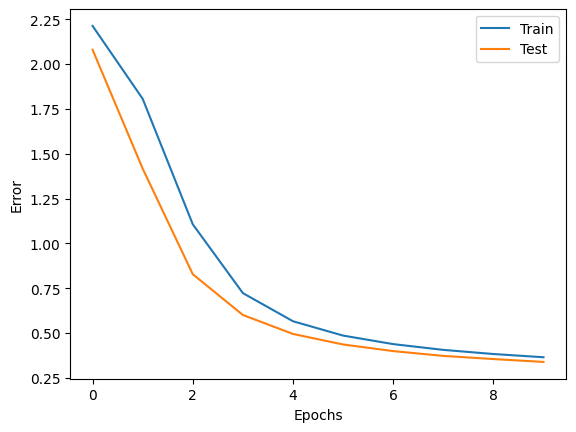

In [18]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## 正解率
モデルの性能を把握するため、テストデータ使い正解率を測定します。  

In [20]:
correct = 0
total = 0
for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()  # GPU対応

    if i == 0:
        print(x.shape)

    #(28,28) を 1次元=784 に変換
    x = x.view(-1, img_size*img_size)

    # 順伝搬（softmax適用前）
    y = net(x)

    # y.argmax(1)で最も値が大きいインデックスを取得
    # sum() で t と同じ値である事を表す True の数の合計を計算
    # item()でpythonの数値に変換
    correct += (y.argmax(1) == t).sum().item()

    # バッチ内の検証データ数(最後のバッチ以外は常に256が加算される)
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

torch.Size([256, 1, 28, 28])
正解率: 90.44%
